# Perguntas a serem respondidas

- Quais são os principais bens materiais comprados pelos órgãos públicos do Rio Grande do Sul?
- É possível identificar algum padrão nas compras? Seja por época do ano ou por tipo de órgão
comprador? 
- O que mais é possível descobrir sobre as licitações do estado?

# Análise dos dados

**Etapas da análise**
1. Após realizar o download dos arquivos, os CSVs para os 4 anos solicitados foram concatenados em um arquivo para realizar a análise completa, nomeando esses arquivos de item.csv e licitacao.csv



2. Ao verificar as colunas DS_OBJETO e DS_ITEM, foi possível verificar que será necessário fazer uma limpeza nos dados para extrair informação útil dos textos. Para realizar essa limpeza foi desenvolvida uma função que realiza diversas transformações no texto, como por exemplo remover os acentos e pontuações e também fazer a lematização* das palavras. 

*A lematização é o ato de representar as palavras através do infinitivo dos verbos e masculino singular dos substantivos e adjetivos.

3. A etapa da lematização* é bastante importante pois, essa etapa reduz as palavras à uma forma simplificada, permitindo agrupar essas palavras para fazer a contagem de ocorrências de maneira mais assertiva e, verificar assim a resposta da primeira pergunta, que é referente a quais os principais bens materiais comprados. Com essa etapa foi possível perceber que os bens mais comprados são relacionados à saúde, educação e transporte, como por exemplo: medicamentos, merenda escolar e pneus. 
*Essa etapa pode ser complicada de realizar em grandes bases de dados, necessitando sabedoria ao implementar as transformações para não gerar códigos muito lentos.

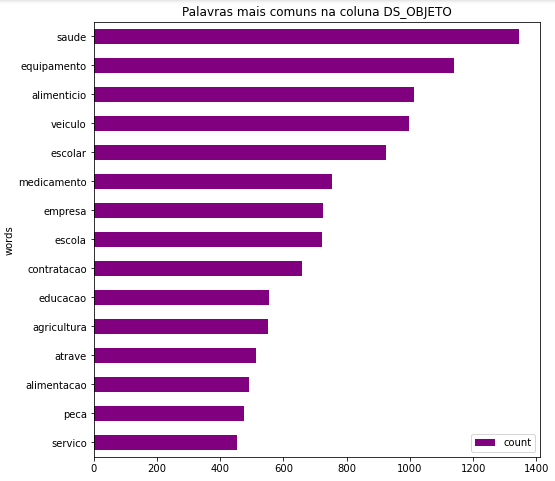



4. Posteriormente, foi realizada uma análise no padrão de compras. Ao observar a coluna NM_ORGAO foi possível verificar que os orgãos compradores mais frequentes são as polícias militares, tendo uma ocorrência bastante expressiva, com 8 PMs entre os 10 órgãos mais frequentes. A palavra 'PM' teve uma frequência de mais de 20% de aparições, sendo a palavra mais frequente da coluna que indica os órgãos.

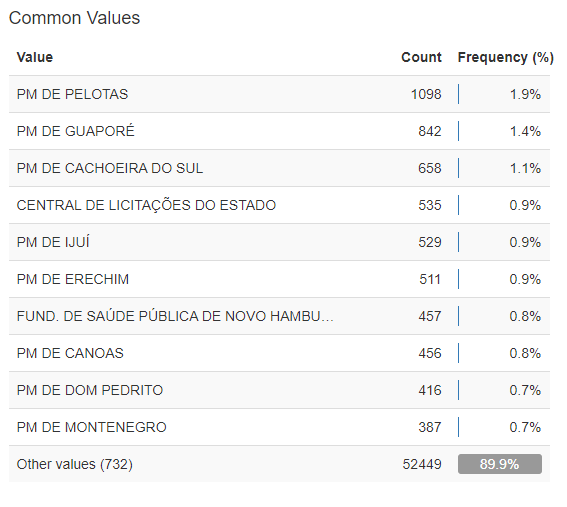

5. Sobre o ano de licitação, houve um aumento expressivo de licitações entre o ano de 2016 e 2017, permanecendo no mesmo patamar em 2018 e com uma leve redução em 2019. O ano de 2017 foi o que teve o maior número de comissões, com mais de 30% das ocorrências. Os valores referentes à ANO_COMISSAO e ANO_PROCESSO apresentam valores algumas vezes ilógicos que provavelmente foram preenchidos incorretamente. O ideal seria que o preenchimento desses valores fosse limitado somente por valores possíveis para que não sejam preenchidos com valores aleatórios e posteriormente prejudiquem a análise dos dados.

6. Além dessas análises, foi interessante perceber que a coluna com o tipo de licitação (TP_LICITACAO) tem alta correlação com a coluna que indica se o orçamento é sigiloso (BL_ORCAMENTO_SIGILOSO). O orçamento sigiloso também tem grande correlação com o tipo de fundamentação (CD_TP_FUNDAMENTACAO), apesar de essa coluna ter mais de 90% de valores faltantes.

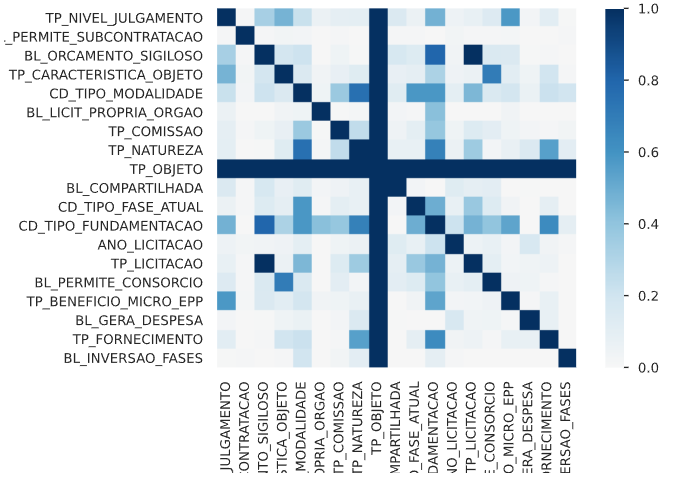

O gráfico acima apresenta a correlação V de Cramer. Esse gráfico aponta as colunas com maior correlação quando esses valores estão mais próximos de 1, e nesse caso, com o azul mais escuro. Quando os valores estão mais próximos de 0 são colunas mais independentes.

Em sequência está o código desenvolvido para realizar as análises:

# Baixar pacotes e importar bibliotecas

In [ ]:
# %pip install --upgrade spacy

# !pip install unidecode

#!python -m spacy download pt_core_news_lg

# import nltk
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('omw-1.4', quiet=True)

In [ ]:
#Frameworks para análise dos dados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

import itertools
import collections

#Frameworks para NLP
import re
import unidecode
from string import punctuation
import spacy
from nltk import FreqDist
from nltk import tokenize, wordnet, ngrams
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import porter

### Coleta de dados

In [ ]:
licitacao_original = pd.read_csv('licitacao.csv')
item_original = pd.read_csv('item.csv')

c:\Users\felip\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,52,53,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#nlp = spacy.load('pt_core_news_sm')
nlp = spacy.load('pt_core_news_lg')

#Conjunto de stopwords em portugues
stopwords_list  = stopwords.words('portuguese')

### Definição de funções

#### Funções para tratamento de Strings

In [ ]:
def remove_accents(a):
    return unidecode.unidecode(a)

def remove_punctuation(df, column):
    for c in punctuation:
        df.loc[:, column] = df.loc[:, column].str.replace(c, "", regex=True)

def cleanData(df, column_in='DS_OBJETO', column_out='OBJETO_CLEAN'):

	#Define coluna de entrada como string
	df[column_in] = df[column_in].astype(str)

	#Cria cópia da coluna de entrada para realizar limpezas
	df.loc[:, column_out] = df.loc[:, column_in].copy()
	
	#Coloca tudo minúsculo
	df.loc[:, column_out] = df.loc[:, column_out].apply(lambda x: x.lower())

	#Remove números
	df.loc[:, column_out] = df.loc[:, column_out].apply(lambda x: re.sub(r'[0-9]+', '', x))
	
	#Remove pontuações
	remove_punctuation(df, column_out);

	#Remove acentuações
	df.loc[:, column_out] = df.loc[:, column_out].apply(remove_accents);

	#Remove espaços vazios
	df.loc[:, column_out] = df.loc[:, column_out].str.strip();
    
	return df

#Essa função precisa ajustar o "value_to_iter" forma que fiquem no máximo 1_000_000 de palavras por iteração
def lemmatizeData(lista_in=[], lista_out=[], loops = int, value_to_iter= int):
    
    #Iterar a cada 10% da lista
    x = 0
    y = value_to_iter

    for i in range(loops):
        x = y
        y = y + value_to_iter
        lista_out.extend([word.lemma_ for word in nlp(str(lista_in[x:y])) if word.pos_ == 'NOUN'])
    return lista_out

def tokenData(df=pd.DataFrame(), column_in='column_in', collection_words=[], loops= 9, value_to_iter=10000): #Esses parametros precisam ser revistos
    
    #tokeniza a coluna de entrada
    tt = TweetTokenizer()
    df['tokenized_text'] = df.loc[:,column_in].apply(tt.tokenize)

    words_in_compras = df['tokenized_text'].to_list()
 
    # Lista todas as palavras do texto
    all_words = list(itertools.chain(*words_in_compras))

    stop_words = stopwords.words('portuguese')

    tokens_sem_stopword = [w for w in all_words if w not in stop_words]

    # Lista todas as palavras EXCETO as inclusas no collection_words
    tokens_s_collection_words = [word for word in tokens_sem_stopword if word not in collection_words]

    tokens_lemma = []
    lemmatizeData(tokens_s_collection_words, tokens_lemma, loops=loops, value_to_iter= value_to_iter)
    
    frequencia = FreqDist(tokens_lemma)

    clean_words = pd.DataFrame(frequencia.most_common(15),
                                columns=['words', 'count'])

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plota gráfico de barras horizontal
    clean_words.sort_values(by='count').plot.barh(x='words',
                        y='count',
                        ax=ax,
                        color="purple")

    ax.set_title("Palavras mais comuns na coluna DS_OBJETO")

    return plt.show()

#### Funções para conversão do tipo dos dados

In [ ]:
def convert_to_categorical(df):
    for col in df.columns:
        if df[col].nunique() < df.shape[0]/300:
            df[col] = df[col].astype('category')

#Essa função pode ser melhorada considerando somente os valores que são digito, OLHAR COM CALMA DEPOIS
def to_float32(row):
    try:
        row = np.float32(row)
        return row 
    except ValueError:
        return np.nan

def colunas_str_to_num(df, columns=[]):
    for column in columns:
        df.loc[:,column] =  df.loc[:,column].apply(to_float32)
    return df

def numeric_to_abs(df):
    columns = df.select_dtypes(include='number').columns
    for column in columns:
        df.loc[:,column] = df.loc[:,column].abs()
    return df

#### Funções para visualização de informações

In [ ]:
def print_unique_values(df):
    for col in df.columns:
        if df[col].nunique() < 10:
            print('----------------------------------------------------------------')
            print(df[col].name)
            print(df[col].unique());

def print_categorical_proportion(df):
  colunas_categoricas = df.select_dtypes(include='category').columns
  for col in colunas_categoricas:
      plt.figure()
      df_col = (df[col].value_counts(dropna=False)/len(df[col]))*100
      df_col.plot(kind='bar')
      plt.title(col)
      plt.ylabel('%', fontsize=10)

In [ ]:
def gera_relatorio_sweetviz(df):
  relatorio = sweetviz.analyze(df)
  return relatorio.show_html('relatorio.html')

def gera_relatorio_profile(df):
    profile = ProfileReport(df)
    return profile.to_notebook_iframe()

# Análise Item

In [ ]:
#print_unique_values(item_original)

In [ ]:
#Armazena em lista 14 ultimas colunas com maior quantidade de NA
columns_to_drop = item_original.isna().sum().sort_values().keys()[-14:]

#Dropa colunas com maior quantidade de NA
item_original.drop(columns_to_drop, axis = 1, inplace = True) 

#convert_to_categorical(item_original)

In [ ]:
numeric_columns = ['QT_ITENS', 'VL_UNITARIO_ESTIMADO', 'VL_TOTAL_ESTIMADO',
                    'VL_UNITARIO_HOMOLOGADO', 'VL_TOTAL_HOMOLOGADO']

colunas_str_to_num(item_original, columns=numeric_columns)
numeric_to_abs(item_original)

,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,TP_RESULTADO_ITEM,VL_UNITARIO_HOMOLOGADO,VL_TOTAL_HOMOLOGADO,TP_DOCUMENTO,NR_DOCUMENTO,TP_BENEFICIO_MICRO_EPP
0,77200,15.0,2016,PRP,1,2,2,"Pneu 1000/20 liso radial, dianteiro, 16 lonas,...",10.0,UN,1500.0,15000.0,A,1430.0,14300.0,J,8774832000177.0,L
1,77200,15.0,2016,PRP,1,4,4,"Pneu 12.4x24 garra baixa, 10 lonas",4.0,UN,1260.0,5040.0,A,1258.0,5032.0,J,8774832000177.0,L
2,77200,15.0,2016,PRP,1,7,7,Pneu 1400x24 mínimo 12 lonas,6.0,UN,2000.0,12000.0,A,1998.0,11988.0,J,8774832000177.0,L
3,77200,15.0,2016,PRP,1,8,8,"Pneu 17.5x25 12 lonas, capacidade mínima de ca...",4.0,UN,3000.0,12000.0,A,2978.0,11912.0,J,8774832000177.0,L
4,77200,15.0,2016,PRP,1,12,12,"Pneu 18.4x30 garra baixa, mínimo 10 lonas",4.0,UN,2600.0,10400.0,A,2500.0,10000.0,J,8774832000177.0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200751,68800,2.0,2019,PRE,1,13,13,Pneu 195/60R15 88V S/C,4.0,UN,336.0,1344.0,A,230.0,920.0,J,17450564000129,N
3200752,68800,2.0,2019,PRE,1,14,14,Pneu 185/70R14 88T S/C,4.0,UN,315.0,1260.0,A,220.0,880.0,J,17450564000129,N
3200753,68800,2.0,2019,PRE,1,15,15,Pneu 7.50-16 10 lonas p/ implemento (Grade),2.0,UN,510.0,1020.0,A,398.0,796.0,J,17450564000129,N
3200754,68800,2.0,2019,PRE,1,17,17,Pneu 6.00-16 / 6 lonas implemento agrícola,2.0,UN,345.0,690.0,A,280.0,560.0,J,17450564000129,N


In [ ]:
item = item_original.copy()
#item = item.sample(500_000, replace=True)

In [ ]:
cleanData(item, column_in='DS_ITEM', column_out='ITEM_CLEAN')

,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,TP_RESULTADO_ITEM,VL_UNITARIO_HOMOLOGADO,VL_TOTAL_HOMOLOGADO,TP_DOCUMENTO,NR_DOCUMENTO,TP_BENEFICIO_MICRO_EPP,ITEM_CLEAN
259480,80000,11.0,2016,PRE,1,5,5,"SOL FISIOLOGICA 0,9% 500 ML SIST FECHADO",570.0,COM,0.00,0.000000,A,2.60,1482.000000,J,94516671000153.0,N,sol fisiologica ml sist fechado
763040,77300,67.0,2017,PRE,1,31,31,Canetões de boa qualidade com 12 unidades (div...,4.0,EMB,13.65,54.599998,A,10.94,43.759998,J,3145819000135,L,canetoes de boa qualidade com unidades divers...
2009770,70000,45.0,2018,PRD,1,1,1,contratação de Empresa para ministrar palestra...,1.0,UN,1500.00,1500.000000,NaN,NaN,NaN,NaN,NaN,NaN,contratacao de empresa para ministrar palestra...
163434,54100,53.0,2016,PRE,10,324,324,"PASTA CATÁLOGO, MATERIAL PAPELÃO REVESTIDO DE ...",4.0,UN,18.60,74.400002,NaN,9.00,36.000000,J,7879956000154.0,NaN,pasta catalogo material papelao revestido de p...
1474453,48800,37.0,2018,PRP,2,6,6,CACHORRO QUENTE,150.0,UN,3.74,561.000000,A,3.74,561.000000,J,5503520000130,L,cachorro quente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66558,77000,3.0,2016,PRE,1,15,15,"Luva de látex, tamanho grande, aplicação limpe...",50.0,PAC,5.76,288.000000,A,2.00,100.000000,J,4415316000103.0,T,luva de latex tamanho grande aplicacao limpeza...
628991,56100,3.0,2017,PRP,1,43,43,ESPONJA PARA BANHO.,50.0,UN,1.50,75.000000,A,1.45,72.500000,J,3828656000195,L,esponja para banho
699587,49900,6.0,2017,PRE,1,42,42,"Peças de viés estreito 100% algodão, nas cores...",15.0,PC,17.50,262.500000,A,12.19,182.850006,J,8574064000108,T,pecas de vies estreito algodao nas cores bran...
2960196,82200,6.0,2019,PRD,1,1,1S,PRESTAÇÃO DE SERVIÇOS DE SONORIZAÇÃO E ANIMAÇÃ...,1.0,UN,3400.00,3400.000000,NaN,0.00,0.000000,NaN,NaN,NaN,prestacao de servicos de sonorizacao e animaca...


In [ ]:
# collection_itens = ['aquisicao','municipal','municipio','municipais', 'registro','preco','uso', 'no', 
#                     'fornecimento', 'licitacao', 'material', 'materiais', 'preco', 'conforme', 'genero',
#                     'secretarias', 'uso', 'edital', 'anexo', 'r', 's', 'i', 'ano', 'secretaria','tipo', 'unidade',
#                     'especificacao', 'necessidade', 'processo', 'demanda', 'cor', 'cm', 'mm', 'kg', 'ml', 'g',
#                     'mg', 'mes', 'data', 'validade', 'm', 'produto']

collection_itens = ['x', 'minimo', 'embalagem', 'c', 'tamanho', 'caixa', 'unidade', 'pvc', 'litro', 'plastico', 
                    'cor', 'cm', 'mm', 'kg', 'ml', 'g', 'mg', 'mes', 'mês',  'm', 'tipo', 'validade', 'data', 'mes', 
                    'qualidade','pacote', 'produto', 'r', 'p', 'litro', 'l', 'mgml', 'material', 'ano' ]

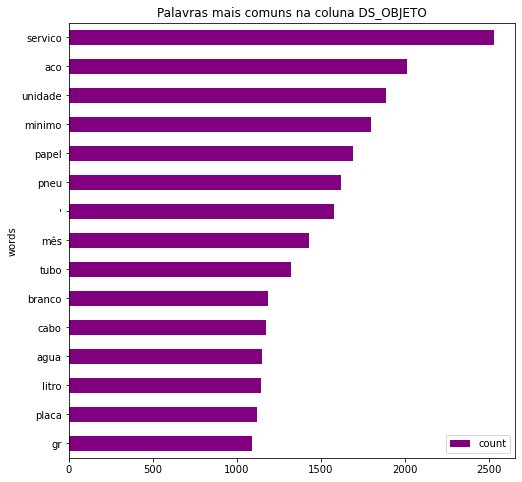

In [ ]:
tokenData(item, column_in='ITEM_CLEAN', collection_words=collection_itens, loops= 10, value_to_iter=10000)

# Análise Licitação - Compras

In [ ]:
#Armazena em lista 14 ultimas colunas com maior quantidade de NA
columns_to_drop = licitacao_original.isna().sum().sort_values().keys()[-30:]

#Dropa colunas com maior quantidade de NA
licitacao_original.drop(columns_to_drop, axis = 1, inplace = True) 

convert_to_categorical(licitacao_original)

In [ ]:
licitacao_COM = licitacao_original[licitacao_original.TP_OBJETO == 'COM']

In [ ]:
licitacao_COM.shape

(82405, 31)

In [ ]:
cleanData(licitacao_COM, column_in='DS_OBJETO', column_out='OBJETO_CLEAN')

C:\Users\felip\AppData\Local\Temp/ipykernel_61660/2044762941.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_in] = df[column_in].astype(str)
c:\Users\felip\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\felip\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_COMISSAO,ANO_COMISSAO,TP_COMISSAO,NR_PROCESSO,ANO_PROCESSO,...,VL_LICITACAO,BL_ORCAMENTO_SIGILOSO,BL_PERMITE_CONSORCIO,DT_ABERTURA,DT_HOMOLOGACAO,DT_ADJUDICACAO,BL_LICIT_PROPRIA_ORGAO,BL_GERA_DESPESA,BL_COMPARTILHADA,OBJETO_CLEAN
1,84100,PM DE ESPERANÇA DO SUL,4.00,2016,CNV,12.0,2016.0,P,003,2016.0,...,11216.50,NaN,N,2016-01-22,2016-01-29,2016-01-29,S,S,N,aquisicao de merenda escolar
2,82701,CM DE XANGRI-LÁ,1.00,2016,PRP,12.0,2016.0,G,01,2016.0,...,NaN,S,N,2016-01-26,2016-02-01,2016-02-01,S,S,N,aquisicao de protocoladora e fragmentadora de ...
3,84100,PM DE ESPERANÇA DO SUL,6.00,2016,CNV,12.0,2016.0,P,005,2016.0,...,59810.60,NaN,N,2016-02-02,2016-02-11,2016-02-11,S,S,N,aquisicao de materiais de limpeza para as dive...
5,53100,PM DE NOVA PALMA,3.00,2016,PRP,6157.0,2016.0,G,07,2016.0,...,251.70,N,N,2016-02-12,2016-02-15,2016-02-15,S,S,N,aquisicao de tubos de concreto
6,86800,PM DE BOA VISTA DO SUL,3.00,2016,PRP,2.0,2016.0,G,004,2016.0,...,31384.90,N,N,2016-01-25,2016-01-28,2016-01-28,S,S,N,aquisicao de tubos de concreto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237002,82901,CM DE ARARICÁ,29.00,2019,PRD,NaN,NaN,NaN,029,2019.0,...,92.91,NaN,N,2019-05-27,NaN,NaN,S,S,N,aquisicao de materiais de limpeza
237003,82901,CM DE ARARICÁ,28.00,2019,PRD,NaN,NaN,NaN,028,2019.0,...,57.80,NaN,N,2019-05-23,NaN,NaN,S,S,N,aquisicao de materiais de limpeza para esta ca...
237005,2304,BRIGADA MILITAR,84509.55,2019,PRI,NaN,NaN,NaN,19/1203-0020582-,2019.0,...,949000.00,NaN,N,2019-09-10,NaN,NaN,S,S,N,cem mil unidades municoes cbc sw cxpo gr coope...
237007,56900,PM DE SANTA MARIA,39.00,2019,PRI,NaN,NaN,NaN,214,2019.0,...,76810.50,NaN,N,2019-05-21,NaN,NaN,S,S,N,fornecimento de passagem escolar urbana


In [ ]:
collection_compras = ['aquisicao','municipal','municipio','municipais', 'registro','preco','uso', 'no', 
                    'fornecimento', 'licitacao', 'material', 'materiais', 'precos', 'conforme', 'generos',
                    'secretarias', 'uso', 'edital', 'anexo', 'r', 's', 'i', 'ano', 'secretaria','tipo', 'unidade',
                    'especificacao', 'necessidade', 'processo', 'demanda' , 'atrave', 'rede']

C:\Users\felip\AppData\Local\Temp/ipykernel_61660/2044762941.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df.loc[:,column_in].apply(tt.tokenize)


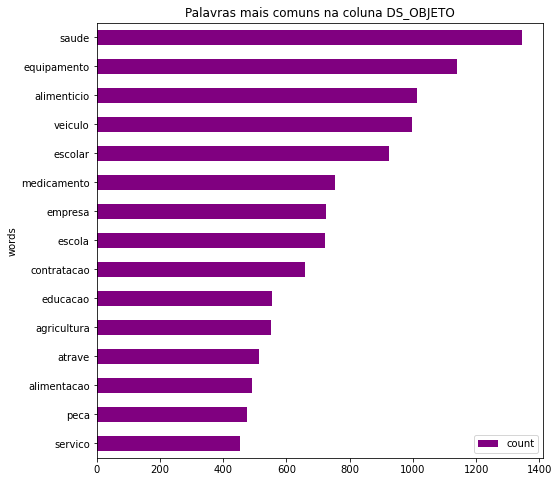

In [ ]:
tokenData(licitacao_COM, column_in='OBJETO_CLEAN', collection_words=collection_compras)

### Visualizar variáveis numéricas

In [ ]:
#compras = licitacao_COM.sample(1000)

In [ ]:
compras = licitacao_COM.query(' VL_LICITACAO < 1_000_000 & NR_LICITACAO < 100 & NR_COMISSAO < 10_000') 
compras.hist(bins=50, figsize=(18,16));

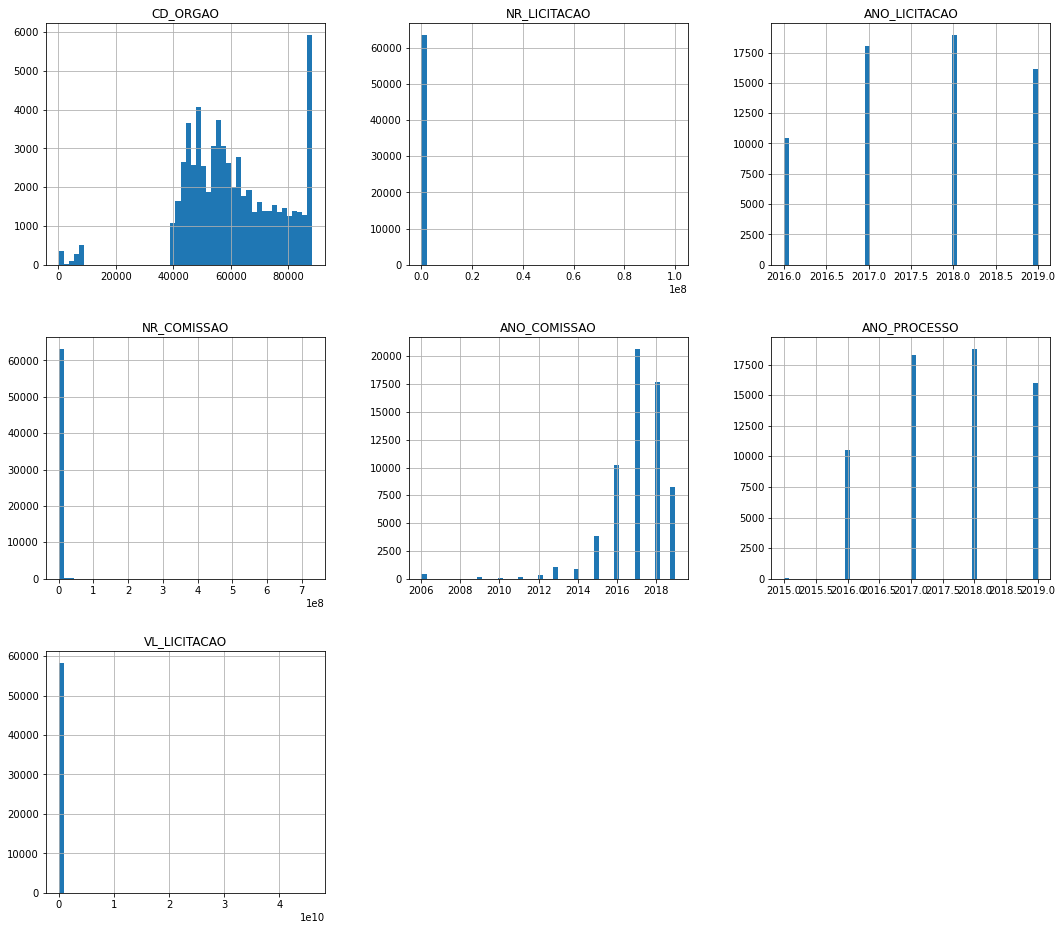

In [ ]:
compras = licitacao_COM.query('ANO_PROCESSO < 2022 & ANO_PROCESSO > 2014 & ANO_COMISSAO > 2000') 
compras.hist(bins=50, figsize=(18,16));

In [ ]:
sns.pairplot(compras, hue="ANO_LICITACAO", plot_kws={'alpha':0.1})

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 0)
sns.scatterplot(data=compras.query('VL_LICITACAO < 100_000_000'), x="DT_ADJUDICACAO", y="VL_LICITACAO", hue="ANO_LICITACAO")

In [ ]:
print_categorical_proportion(compras)

In [ ]:
licitacao_to_profile = licitacao_COM.drop(['tokenized_text','OBJETO_CLEAN', 'DS_OBJETO'], axis = 1).query('NR_LICITACAO < 9_999_999_999 & NR_COMISSAO < 100_000_000 & VL_LICITACAO < 100_000_000')

In [ ]:
gera_relatorio_profile(licitacao_to_profile)

In [ ]:
gera_relatorio_sweetviz(licitacao_original)

In [ ]:
#gera_relatorio_sweetviz(licitacao_COM)